In [1]:
import numpy as np
from scipy.spatial import distance
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.metrics import normalized_mutual_info_score

from src.colorconv import ConvexCluster
from src.util import (compression,
                      informativeness,
                      non_dominated_front)
import statsmodels.api as sm

np.seterr(divide='ignore', invalid='ignore')

NOISE = 0
NUMBER = 3
SHAPE = (4, 4)

In [2]:
coords = np.array(np.meshgrid(np.arange(SHAPE[0]), np.arange(SHAPE[1]))).T.reshape(-1, 2)
coords = [tuple(i) for i in coords]

In [3]:
# dictionary mapping coords to themselves
coords_dict = defaultdict(list)
for i, coord in enumerate(coords):
    coords_dict[tuple(coord)] = tuple(coord)

In [4]:
LS = []

for _ in range(10000):

    lexicons = ConvexCluster(X = np.zeros(SHAPE), 
                            d = 1.5, 
                            N = NUMBER, 
                            s = np.random.uniform(0.8, 1), 
                            c = np.random.uniform(0, 0.1),
                            coords=coords,
                            reverse_labels=coords_dict)
    lexicons = lexicons.run()
    LS.append(lexicons)

LS = np.array(LS)
# convert values to integers
LS = LS.astype(int)

In [5]:
def point_in_hull(point, hull):
    '''
    Check if a point is inside the convex hull.
    '''
    return all((np.dot(eq[:-1], point) + eq[-1] <= 0) for eq in hull.equations)

def degree_of_convexity_cluster(cluster_points):
    '''
    Build the convex hull around cluster. 
    Find the number of points in the hull. 
    Divide the number of points in the class 
    by the number of points inside the hull
    '''
    if len(cluster_points) < 4:
        return 1
    else:
        try:
            hull = ConvexHull(cluster_points)
            in_hull = [p for p in cluster_points if point_in_hull(p, hull)]
            return len(in_hull) / (len(cluster_points) + 1)
        except:
            return 0 

def degree_of_convexity(arrays):
    '''Compute the degree of convexity for the given array or arrays'''
    convexity_list = []
    for arr in arrays:
        labels = np.unique(arr)  # Get unique labels
        convexities = [degree_of_convexity_cluster(np.argwhere(arr == label)) for label in labels]
        weights = [np.sum(arr == label) for label in labels]
        convexity = np.average(convexities, weights=weights)
        convexity_list.append(convexity)
    return np.array(convexity_list)

# Given arrays
arrays = np.array([[[2, 2, 2, 0],
                    [1, 0, 0, 2],
                    [0, 2, 2, 1],
                    [0, 1, 1, 2]],

                   [[1, 2, 1, 0],
                    [2, 0, 2, 2],
                    [2, 0, 1, 0],
                    [2, 1, 1, 2]],

                   [[1, 2, 2, 2],
                    [1, 2, 1, 1],
                    [1, 2, 0, 0],
                    [2, 2, 0, 1]],

                   [[0, 1, 2, 0],
                    [1, 2, 1, 1],
                    [0, 2, 2, 1],
                    [0, 1, 2, 1]],

                   [[2, 1, 2, 2],
                    [0, 2, 2, 1],
                    [0, 2, 0, 0],
                    [0, 2, 1, 2]]])

convexities = degree_of_convexity(arrays)
print("Degrees of Convexity:", convexities)

Degrees of Convexity: [0.84322917 0.84322917 0.83816964 0.78854167 0.84027778]


In [6]:
arrays.shape

(5, 4, 4)

In [7]:
class BaseRSA:
    def __init__(self, alpha, prior):
        self.alpha = alpha
        self.prior = prior

    @staticmethod
    def safelog(vals):
        with np.errstate(divide='ignore'):
            return np.log(vals)
        
    @staticmethod
    def binary_language(L):
        max_labels = np.max([np.max(subarray) for subarray in L]) + 1
        binary_arrays = []
        for subarray in L:
            x = max_labels
            y = np.prod(subarray.shape)
            binary_array = np.zeros((x, y), dtype=np.uint8)
            for i, row in enumerate(subarray):
                for j, val in enumerate(row):
                    binary_array[val, i * subarray.shape[1] + j] = 1
            binary_arrays.append(binary_array)
        return np.array(binary_arrays)
    
    @staticmethod
    def normalize(vals):
        return np.nan_to_num(vals / np.sum(vals, axis=-1, keepdims=True))
    
    @staticmethod
    def cost(L):
        # for each unique label, compute pairwise distance between all points
        # and sum them up
        cost_arrays = []
        unique_labels = np.unique(L)
        for subarray in L:
            cost_p = np.zeros(max(unique_labels) + 1)
            for c in unique_labels:
                coords = np.argwhere(subarray == c)
                for m in coords:
                    for n in coords:
                        cost_p[c] += distance.euclidean(m, n)
                cost_p[c] = cost_p[c] / (len(coords) * (len(coords)))
            cost_arrays.append(cost_p)
        return np.nan_to_num(np.expand_dims(np.array(cost_arrays), axis=1))

    def L_0(self, L):
        '''Literal listener'''
        return self.normalize(self.binary_language(L) * self.prior )  
        # *  self.informativeness(L)
    
    def S_p(self, L):
        return self.normalize(np.exp(self.alpha * (self.safelog(self.L_0(L).transpose(0, 2, 1)))))
        # return self.normalize(np.exp(self.alpha * (self.safelog(self.L_0(L).transpose(0, 2, 1)) - self.cost(L))))
    
    def L_p(self, L):
        return self.normalize(self.S_p(L).transpose(0, 2, 1) * self.prior)
        # * self.informativeness(L)


In [39]:
class Agent(BaseRSA):
    def __init__(self, alpha, prior, shape, convex, Lexicons, convexities, treshold, beta, simple):
        super().__init__(alpha, prior)
        self.n_meanings = shape[0] * shape[1]

        self.Lexicons = Lexicons
        self.convexities = convexities

        self.convex = convex
        self.beta = beta
        self.simple = simple
        
        self.Lexicons = self.Lexicons[self.convexities > treshold]
        self.convexities = self.convexities[self.convexities > treshold]

        if simple:
            self.simplicity = [-compression(subarray) for subarray in self.Lexicons]
            # simplcity should be in 0-1 range
            self.simplicity = np.array((self.simplicity - np.min(self.simplicity)) \
                                       / (np.max(self.simplicity) - np.min(self.simplicity)))

        
        self.prob_lexicon = np.ones(len(self.Lexicons)) / len(self.Lexicons)

        self.precompute_S_p()
        self.precompute_L_p()

        self.n_words = np.max([np.max(subarray) for subarray in self.Lexicons]) + 1
        self.n_meanings = shape[0] * shape[1]
    
    def precompute_S_p(self):
        self.S_p_values = self.S_p(self.Lexicons)
    
    def precompute_L_p(self):
        self.L_p_values = self.L_p(self.Lexicons)
    
    def speaker(self, m):
        lexicon_idx = np.random.choice(np.arange(len(self.Lexicons)), p=self.prob_lexicon)
        if np.sum(self.S_p_values[lexicon_idx][m]) == 0:
            return np.random.choice(np.arange(self.n_words), p=[1 / self.n_words] * self.n_words)
        else:
            return np.random.choice(np.arange(self.n_words), p=self.S_p_values[lexicon_idx][m])
    
    def listener(self, w):
        lexicon_idx = np.random.choice(np.arange(len(self.Lexicons)), p=self.prob_lexicon)
        if np.sum(self.L_p_values[lexicon_idx][w]) == 0:
            return np.random.choice(np.arange(self.n_meanings), p=[1 / self.n_meanings] * self.n_meanings)
        else:
            return np.random.choice(np.arange(self.n_meanings), p=self.L_p_values[lexicon_idx][w])

    def update(self, w, m, correct, role):
        if self.convex:
            self.prob_lexicon = self.normalize(self.convexities**(1/self.beta) * self.prob_lexicon)
        if self.simple:
            self.prob_lexicon = self.normalize(self.simplicity**(1/self.beta) * self.prob_lexicon)
        if role == "speaker":
            if correct:
                self.prob_lexicon = self.normalize(self.S_p_values[:, m, w] \
                                                    * self.prob_lexicon + NOISE)
        elif role == "listener":
            if correct:
                self.prob_lexicon = self.normalize(self.L_p_values[:, w, m] \
                                                        * self.prob_lexicon  + NOISE)


class Experiment:
    def __init__(self, alpha, prior, shape, n, n_iter, n_rounds, Lexicons, convex, treshold, beta, simple):
        self.n_iter = n_iter
        self.n_rounds = n_rounds

        # self.logs = defaultdict(lambda: defaultdict(dict))
        
        self.logs = {}

        self.alpha = alpha
        self.prior = prior
        self.convex = convex
        self.simple = simple

        self.treshold = treshold
        self.beta = beta

        self.shape = shape
        if n > 300000:
            self.n = 300000
        else:
            self.n = n 
            self.treshold = 0

        self.Lexicons = Lexicons


    def sample_meaning(self):
        return np.random.choice([i for i in range(self.shape[0] * self.shape[1])])

    def one_round(self, a, b, m, i, r):
        w = a.speaker(m)
        g = b.listener(w)

        a.update(w, m, m == g, "speaker")
        b.update(w, m, m == g, "listener")
    
    def run(self):
        
        # Lexicons = generate_lexicons(N=self.N, shape=self.shape, n=self.n)
        ####### !!!!!!!! #######
        # NB: computing on lexicons from ColorConvex 
        # Lexicons = LS 
        ####### !!!!!!!! #######
        convexities = degree_of_convexity(self.Lexicons)
        
        for i in range(self.n_iter):
            p1 = np.random.permutation(len(self.Lexicons))
            p2 = np.random.permutation(len(self.Lexicons))
            agents = [Agent(alpha=self.alpha, prior=self.prior,
                            shape=self.shape, convex=self.convex, 
                            Lexicons= self.Lexicons[p1], convexities=convexities[p1], 
                            treshold=self.treshold, beta=self.beta, simple=self.simple),
                      Agent(alpha=self.alpha, prior=self.prior,
                            shape=self.shape, convex=self.convex, 
                            Lexicons=self.Lexicons[p2], convexities=convexities[p2], 
                            treshold=self.treshold, beta=self.beta, simple=self.simple)]

            lexicons_ = {'a1': [], 'a2': []}
            for r in range(self.n_rounds):

                lexicons_['a1'].append(agents[0].Lexicons[np.argmax(agents[0].prob_lexicon)])
                lexicons_['a2'].append(agents[1].Lexicons[np.argmax(agents[1].prob_lexicon)])
                
                m = self.sample_meaning()

                if r % 2 == 0:
                    self.one_round(agents[0], 
                                   agents[1], 
                                   m, i, r)
                else:
                    self.one_round(agents[1], 
                                   agents[0], 
                                    m, i, r)
                

            self.logs[i] = lexicons_

In [40]:
def plot_last_lexicons(model, n_iter, pos=-1):
    fig, ax = plt.subplots(2, 10)

    for i, l in enumerate(np.random.choice(range(n_iter), 10, replace=False)):
        ax[0, i].imshow(model.logs[l]['a1'][pos], cmap='tab20', interpolation='none')
        ax[1, i].imshow(model.logs[l]['a2'][pos], cmap='tab20', interpolation='none')  
        # remove axes 
        ax[0, i].axis('off')
        ax[1, i].axis('off') 

        # add iteration number on top
        ax[0, i].set_title(f"{i}") 

    # add labels on the left saying A1 A2
    ax[0, 0].set_ylabel('A1')
    ax[1, 0].set_ylabel('A2')
    plt.tight_layout()
    # remove gaps between subplots    plt.show()

In [41]:
def calculate_normalized_mutual_info(data, n_iter, n_rounds):
    mis = []

    for k in range(n_iter):
        mi = []
        for i in range(n_rounds):
            mi.append(normalized_mutual_info_score(data.logs[k]['a1'][i].ravel(), 
                                                  data.logs[k]['a2'][i].ravel()))

        mis.append(mi)

    df = pd.DataFrame(mis).melt()
    return df

## Single N example

In [42]:
n_iter = 100
n_rounds = 200
N = NUMBER
shape = SHAPE

In [43]:
# L = generate_lexicons(N, shape, calculate_upper_bound(N, shape))

# degree_of_convexity(L)

In [54]:
a = Experiment(alpha=1, 
               shape=shape, 
               n=len(LS), 
               n_iter=n_iter, 
               n_rounds=n_rounds,
               prior= np.ones(shape[1] * shape[0]) / shape[1] * shape[0], 
               convex=True, # convexity bias
               treshold=0, # no treshold
               beta=0.01, # strong convexity bias
               Lexicons=LS,
               simple=False) # simplicity bias)
a.run()
mi_convex = calculate_normalized_mutual_info(a, n_iter, n_rounds)

In [55]:
b = Experiment(alpha=1, 
               shape=shape, 
               n=len(LS), 
               n_iter=n_iter, 
               n_rounds=n_rounds,
               prior= np.ones(shape[1] * shape[0]) / shape[1] * shape[0], 
               convex=False, # no convexity bias
               treshold=0, # no treshold
               beta=1, # no skew towards convex lexicons
               Lexicons=LS,
               simple=False) # simplicity bias)
b.run()
mi_nconvex = calculate_normalized_mutual_info(b, n_iter, n_rounds)

In [56]:
c = Experiment(alpha=1,
                shape=shape, 
                n=len(LS), 
                n_iter=n_iter, 
                n_rounds=n_rounds,
                prior= np.ones(shape[1] * shape[0]) / shape[1] * shape[0], 
                convex=False, # convexity bias
                treshold=0, # no treshold
                beta=0.01, # no skew towards convex lexicons
                Lexicons=LS,
                simple=True) # simplicity bias)
c.run()
mi_simple = calculate_normalized_mutual_info(c, n_iter, n_rounds)

In [57]:
# generate 1000 random matrices and compute the baseline
baseline = []

# for i in range(1000):
#     baseline.append(normalized_mutual_info_score(np.random.randint(0, N, shape).ravel(),   
#                                                  np.random.randint(0, N, shape).ravel()))

# sample randomly from LS and compute the baseline
for i in range(1000):
    baseline.append(normalized_mutual_info_score(LS[np.random.choice(range(len(LS)))].ravel(),   
                                                 LS[np.random.choice(range(len(LS)))].ravel()))

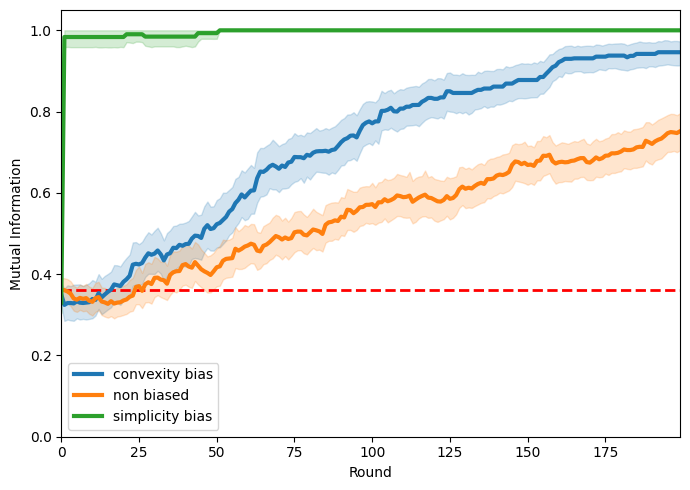

In [62]:
fig, ax = plt.subplots(figsize=(7, 5))
# for mi in mis:
#     plt.plot(mi, color = 'blue', alpha=0.05, linewidth=3)
# plot mean mutual information
# plot the baseline
plt.axhline(y=np.mean(baseline), 
            color='r', 
            linestyle='--', 
            linewidth=2, 
            alpha=1)
sns.lineplot(x="variable", 
             y="value", 
             data=mi_convex,
             linewidth=3,
             label='convexity bias')
sns.lineplot(x="variable", 
             y="value", 
             data=mi_nconvex,
             linewidth=3,
             label='non biased')
sns.lineplot(x="variable",
             y="value",
             data=mi_simple,
             linewidth=3,
             label='simplicity bias')
plt.ylim(0, 1.05)
plt.xlabel('Round')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.legend()
# log space y 
# ax.set_yscale('log')
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# ax.minorticks_on()
plt.margins(x=0)
plt.show()

In [63]:
# for every variable in mi_nconvex, add a new column with range(n_iter) and then melt the dataframe
mi_nconvex['group'] = list(range(n_iter)) * n_rounds
mi_convex['group'] = list(range(n_iter)) * n_rounds
mi_simple['group'] = list(range(n_iter)) * n_rounds

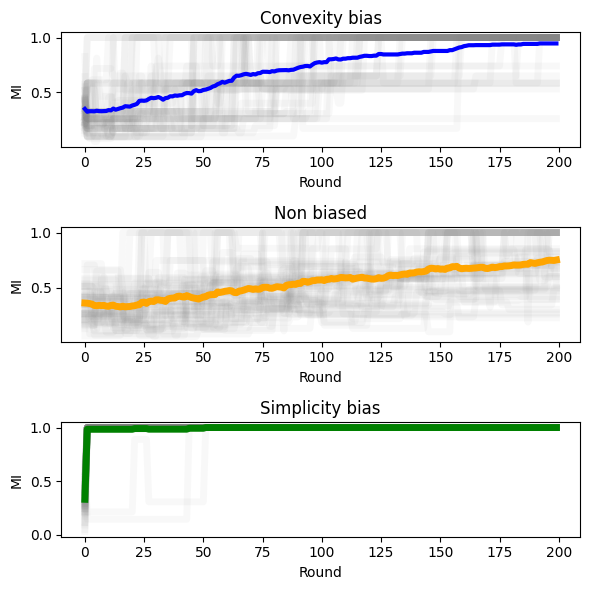

In [77]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6))

# Convex subplot
ax1.set_title('Convexity bias')
for group in mi_convex.group.unique():
    if group % 2 == 0:
        ax1.plot(range(n_rounds), mi_convex[mi_convex.group == group].value, 
                 color='grey', alpha=0.05, linewidth=5)

# plot mean mutual information by grouping by variable
ax1.plot(range(n_rounds), mi_convex.groupby('variable').value.mean(), color='blue', linewidth=3)

# Non-convex subplot
ax2.set_title('Non biased')
for group in mi_nconvex.group.unique():
    if group % 2 == 0:
        ax2.plot(range(n_rounds), mi_nconvex[mi_nconvex.group == group].value, 
                 color='grey', alpha=0.05, linewidth=5)

# plot mean mutual information by grouping by variable
ax2.plot(range(n_rounds), mi_nconvex.groupby('variable').value.mean(), color='orange', linewidth=5)

# Simplicity subplot
ax3.set_title('Simplicity bias')
for group in mi_simple.group.unique():
    if group % 2 == 0:
        ax3.plot(range(n_rounds), mi_simple[mi_simple.group == group].value, 
                 color='grey', alpha=0.05, linewidth=5)

# plot mean mutual information by grouping by variable
ax3.plot(range(n_rounds), mi_simple.groupby('variable').value.mean(), color='green', linewidth=5)

ax1.set_xlabel('Round')
ax1.set_ylabel('MI')
ax2.set_ylabel('MI')
ax3.set_ylabel('MI')
ax2.set_xlabel('Round')
ax3.set_xlabel('Round')

plt.tight_layout()
plt.show()


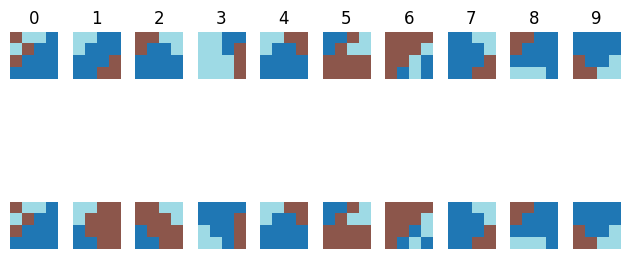

In [78]:
plot_last_lexicons(a, n_iter, pos=-1)

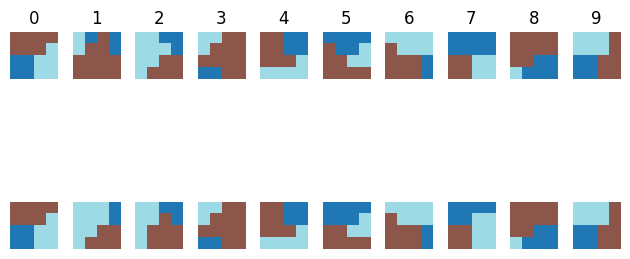

In [79]:
plot_last_lexicons(b, n_iter, pos=-1)

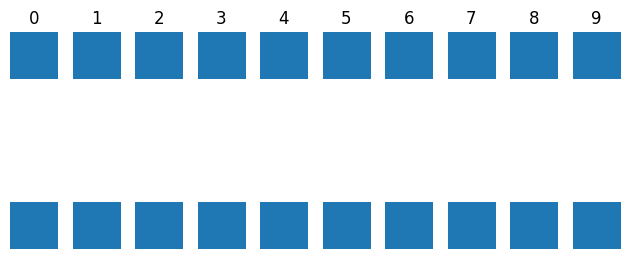

In [80]:
plot_last_lexicons(c, n_iter, pos=-1)

## Running with multiple N

In [81]:
def generate_lexicons(N, shape, n):

    LS = []

    for _ in range(n):

        lexicons = ConvexCluster(X=np.zeros(shape),
                                 d=1.5,
                                 N=N,
                                 s=np.random.uniform(0.5, 1),
                                 c=np.random.uniform(0, 0.5),
                                 coords=coords,
                                 reverse_labels=coords_dict)
        lexicons = lexicons.run()
        LS.append(lexicons)

    LS = np.array(LS)
    # convert values to integers
    LS = LS.astype(int)
    
    return LS

In [82]:
def generate_coords(shape):
    coords = np.array(np.meshgrid(np.arange(shape[0]), 
                                  np.arange(shape[1]))).T.reshape(-1, 2)
    coords = [tuple(i) for i in coords]

    # dictionary mapping coords to themselves
    coords_dict = {coord: coord for coord in coords}
    
    return coords, coords_dict

In [83]:
def efficiency_simplicity_analysis(n, shape, N_min, N_max):

    n_iter = 100
    n_rounds = 200

    LS_ = []
    convex_lexicons = []
    non_convex_lexicons = []
    simplicity_lexicons = []

    coords, coords_dict = generate_coords(shape)

    for N in range(N_min, N_max):

        LS = generate_lexicons(N, shape, n)

        # prior = np.ones(shape[1] * shape[0]) / shape[1] * shape[0]
        
        a = Experiment(alpha=1, 
               shape=shape, 
               n=len(LS), 
               n_iter=n_iter, 
               n_rounds=n_rounds,
               prior= np.ones(shape[1] * shape[0]) / shape[1] * shape[0], 
               convex=True,
               treshold=0,
               beta=0.05,
               Lexicons=LS,
               simple=False)
        a.run()

        convex_lexicons.append([a.logs[i]['a1'][-1] for i in range(n_iter)])

        b = Experiment(alpha=1,
                shape=shape,
                n=len(LS),
                n_iter=n_iter,
                n_rounds=n_rounds,
                prior= np.ones(shape[1] * shape[0]) / shape[1] * shape[0],
                convex=False,
                treshold=0,
                beta=1,
                Lexicons=LS,
                simple=False)
        b.run()

        non_convex_lexicons.append([b.logs[i]['a1'][-1] for i in range(n_iter)])

        c = Experiment(alpha=1,
                    shape=shape,
                    n=len(LS),
                    n_iter=n_iter,
                    n_rounds=n_rounds,
                    prior= np.ones(shape[1] * shape[0]) / shape[1] * shape[0],
                    convex=False,
                    treshold=0,
                    beta=0.05,
                    Lexicons=LS,
                    simple=True)
        c.run()

        simplicity_lexicons.append([c.logs[i]['a1'][-1] for i in range(n_iter)])

        LS_.append(LS)

    # # flatten the list of lists lexicons
    # lexicons_convex = [item for sublist in lexicons_convex for item in sublist]
    # lexicons_nconvex = [item for sublist in lexicons_nconvex for item in sublist]
    # flatten the list of lists lexicons
    convex_lexicons = [item for sublist in convex_lexicons for item in sublist]
    non_convex_lexicons = [item for sublist in non_convex_lexicons for item in sublist]
    simplicity_lexicons = [item for sublist in simplicity_lexicons for item in sublist]

    # flatten LS_
    LS_ = [item for sublist in LS_ for item in sublist]
    
    return convex_lexicons, non_convex_lexicons, simplicity_lexicons, LS_, coords, coords_dict
        

In [113]:
lexicons_convex, lexicons_nconvex, lexicons_simple, LS_, coords, coords_dict = efficiency_simplicity_analysis(10000, (6, 6), 2, 12)

In [ ]:
# compute simplicity and informativeness for all types of models
simplicity_convex = [compression(lexicon) for lexicon in lexicons_convex]
informativeness_convex = [informativeness(lexicon, p_m=None, cielab_dict=coords_dict) for lexicon in lexicons_convex]

simplicity_nconvex = [compression(lexicon) for lexicon in lexicons_nconvex] 
informativeness_nconvex = [informativeness(lexicon, p_m=None, cielab_dict=coords_dict) for lexicon in lexicons_nconvex]

simplicity_simple = [compression(lexicon) for lexicon in lexicons_simple]
informativeness_simple = [informativeness(lexicon, p_m=None, cielab_dict=coords_dict) for lexicon in lexicons_simple]

# compute simplicity for the prior
simplicity_prior = [compression(l) for l in LS_]

informativeness_prior = [informativeness(l, p_m=None, cielab_dict=coords_dict) for l in LS_]

In [ ]:
pareto_front_indices = non_dominated_front(simplicity_prior, informativeness_prior) 
pareto_front_points = [(simplicity_prior[i], informativeness_prior[i]) for i in pareto_front_indices]

In [ ]:
# find duplicates in either x or y and remove them
pareto_front_points = list(set(pareto_front_points))
x_pareto, y_pareto = zip(*pareto_front_points)

# create a smooth line over x_pareto and y_pareto using lowess
lowess = sm.nonparametric.lowess
smoothed = lowess(y_pareto, x_pareto)

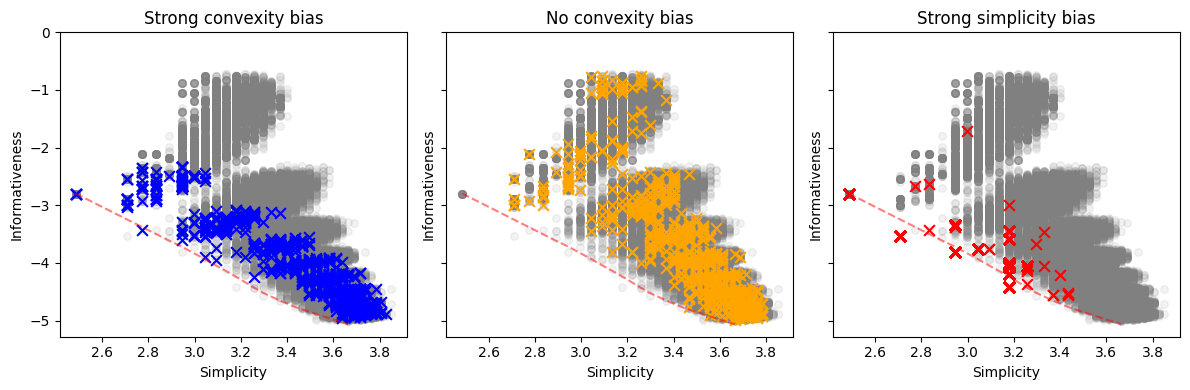

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# Convex subplot
ax1.scatter(simplicity_prior, informativeness_prior, alpha=0.1, color='grey', s=30)
ax1.scatter(simplicity_convex, informativeness_convex, alpha=1, marker='x', color='blue', s=60)
ax1.set_xlabel('Simplicity')
ax1.set_ylabel('Informativeness')
ax1.set_title('Strong convexity bias')
ax1.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=0.5)

# Non-convex subplot
ax2.scatter(simplicity_prior, informativeness_prior, alpha=0.1, color='grey', s=30)
ax2.scatter(simplicity_nconvex, informativeness_nconvex, alpha=1, marker='x', color='orange', s=60)
ax2.set_xlabel('Simplicity')
ax2.set_ylabel('Informativeness')
ax2.set_title('No convexity bias')
ax2.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=0.5)

# Simplicity subplot
ax3.scatter(simplicity_prior, informativeness_prior, alpha=0.1, color='grey', s=30)
ax3.scatter(simplicity_simple, informativeness_simple, alpha=1, marker='x', color='red', s=60)
ax3.set_xlabel('Simplicity')
ax3.set_ylabel('Informativeness')
ax3.set_title('Strong simplicity bias')
ax3.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=0.5)

# set ylim at 0 to -inf
ax1.set_ylim(None, 0)
ax2.set_ylim(None, 0)
ax3.set_ylim(None, 0)

plt.tight_layout()
plt.show()

In [ ]:
distance.euclidean((2.772588722239781, -2.3463938398495827), (2.772588722239781, -2.3463938398495827))

0.0

In [ ]:
# for each type of model, compute the average distance to the pareto front
# use from sklearn.metrics.pairwise import euclidean_distances

from sklearn.metrics.pairwise import euclidean_distances

# compute the distance between the pareto front and the points
distances_convex = euclidean_distances([(simplicity, informativeness) for simplicity, informativeness in zip(simplicity_convex, informativeness_convex)], 
                                      smoothed)

distances_nconvex = euclidean_distances([(simplicity, informativeness) for simplicity, informativeness in zip(simplicity_nconvex, informativeness_nconvex)],
                                        smoothed)

distances_simple = euclidean_distances([(simplicity, informativeness) for simplicity, informativeness in zip(simplicity_simple, informativeness_simple)],
                                        smoothed)

(0.0, 3.0)

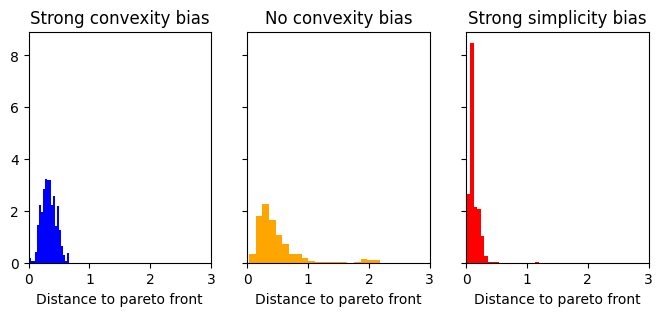

In [ ]:

# plot the distances using matplotlib
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3), sharey=True)

# Convex subplot
ax1.hist(np.min(distances_convex, axis=1), bins=20, color='blue', density=True)
ax1.set_xlabel('Distance to pareto front')
# ax1.set_ylabel('Frequency')
ax1.set_title('Strong convexity bias')

# Non-convex subplot
ax2.hist(np.min(distances_nconvex, axis=1), bins=20, color='orange', density=True)
ax2.set_xlabel('Distance to pareto front')
# ax2.set_ylabel('Frequency')
ax2.set_title('No convexity bias')

# Simplicity subplot
ax3.hist(np.min(distances_simple, axis=1), bins=20, color='red', density=True)
ax3.set_xlabel('Distance to pareto front')
# ax3.set_ylabel('Frequency')
ax3.set_title('Strong simplicity bias')

# set xlim to 0, 3 for every subplot
ax1.set_xlim(0, 3)
ax2.set_xlim(0, 3)
ax3.set_xlim(0, 3)


In [ ]:
# print average distance to pareto front as a table
print("Average distance to pareto front")
print("Strong convexity bias:", np.mean(np.min(distances_convex, axis=1)))
print("No convexity bias:", np.mean(np.min(distances_nconvex, axis=1)))
print("Strong simplicity bias:", np.mean(np.min(distances_simple, axis=1)))

Average distance to pareto front
Strong convexity bias: 0.3346837337630138
No convexity bias: 0.47996828710593514
Strong simplicity bias: 0.1160348224905017
